In [ ]:
# default_exp widgets

# Widgets
> This module contains widgets to perform selected tasks such as viewing/modifying plots interactively.

In [ ]:
#export
import plotly.graph_objects as go
import numpy as np
import shutil
from IPython.display import display,HTML
from ipywidgets import interact, Layout,Label,Button, Box,HBox,VBox
import ipywidgets as ipw
import os,json
from datetime import datetime
import pivotpy as pp 

[HTML STYLES REFERENCE](https://github.com/jupyter-widgets/ipywidgets/blob/master/packages/controls/css/widgets-base.css)

In [ ]:
#export
light_style = """<style>
               .widget-text input { 
                   background-color:white !important;
                   border-radius:20px !important; 
                   padding: 0px 10px 0px 10px !important;
                   border: 1px solid #e0e8e8 !important;
                   color: gray !important;
                   }
               .widget-text input:focus {
                   border: 1px solid skyblue !important;
                   }
               .widget-text input:hover { 
                   border: 1px solid skyblue !important;
                   }
               .widget-dropdown > select {
                   background-color: transparent !important;
                   border:none !important;
                   border-bottom: 1px solid skyblue !important;
                   box-shadow: inset 0 -20px 10px -20px skyblue;
               }
               .widget-dropdown > select:hover {
                   background-color: white !important;
               }
               .widget-dropdown > select > option {
                   color: gray !important;
                   background-color: #eaf0f0 !important;
               }
               .widget-dropdown > select > option:focus {
                   background-color: red !important;
               }
               .widget-box { 
                   background-color:#eaf0f0 !important;
                   border-radius:5px !important; 
                   padding:10px !important;
                   border: 1px solid whitesmoke !important;
                   box-shadow: 1px 1px 1px 1px gray !important;
                }
                .p-Collapse {
                    display: flex;
                    flex-direction: row;
                    align-items: stretch;
                    
                }
                .p-Accordion .p-Collapse + .p-Collapse {
                    margin-top: 0px;
                }
                .borderless {
                border: 1px solid transparent !important;
                box-shadow: none !important;
                border-radius: 0px !important;
                margin:4px !important;
                }
                .marginless {
                    margin: 0px !important;
                    border-radius: 0px !important;
                }
                .widget-tab {
                   background-color:#eaf0f0 !important;  
                   border: 1px solid whitesmoke !important;
                   box-shadow: 1px 1px 1px 1px gray !important;
                }
            </style>"""

dark_style = """<style>
               .widget-text input { 
                   background-color:black !important;
                   border-radius:20px !important; 
                   padding: 0px 10px 0px 10px !important;
                   border: 1px solid #404040 !important;
                   color: #abb2bf !important;
                   }
               .widget-text input:focus {
                   border: 1px solid skyblue !important;
                   }
               .widget-text input:hover { 
                   border: 1px solid skyblue !important;
                   }
               .widget-dropdown > select {
                   background-color: transparent !important;
                   border:none !important;
                   border-bottom: 1px solid skyblue !important;
                   box-shadow: inset 0 -20px 10px -20px skyblue;
                   color: white !important;
               }
               .widget-dropdown > select:hover {
                   background-color: black !important;
               }
               .widget-dropdown > select > option {
                   color: whitesmoke !important;
                   background-color: black !important;
               }
               .widget-dropdown > select > option:focus {
                   background-color: red !important;
               }
               .widget-label {
                   color: white !important;
               }
               .widget-html {
                   color: white !important;
               }
               .widget-box { 
                   background-color:#282c34 !important;
                   border-radius:5px !important; 
                   padding:10px !important;
                   border: 1px solid black !important;
                   box-shadow: 1px 1px 1px 1px black !important;
                }
                .borderless {
                border: 1px solid transparent !important;
                box-shadow: none !important;
                border-radius: 4px !important;
                margin:4px !important;
                }
                .marginless {
                    margin: 0px !important;
                    border-radius: 0px !important;
                }
                .widget-tab {
                   background-color:#eaf0f0 !important;  
                   border: 1px solid whitesmoke !important;
                   box-shadow: 1px 1px 1px 1px gray !important;
                }
            </style>"""

In [ ]:
#export
def get_files_gui(auto_fill = 'vasprun.xml',html_style=None,height=320):
    """
    - Creates a GUI interface for files/folders filtering.
    - **Parmeters**
        - auto_fill  : Default is `vasprun.xml`, any file/folder.
        - html_style : None,`dark_style` or `light_style`.
        - height     : Height of Grid box.
    - **Returns**
        - Tuple(GUI_gridbox,Files_Dropdown). Access second one by item itself. 
    """
    files_w = ipw.Dropdown(continuous_update=False)
    pw = ipw.Text(value=os.getcwd())

    incldue_w = ipw.Text(value=auto_fill)

    excldue_w = ipw.Text()
    layout = Layout(width='max-content')
    depth_w = ipw.Dropdown(options=[None,1,2,3,4,5],value=4,layout=layout)
    item_w = ipw.Dropdown(options=['Both','Files','Folders'],value='Files',layout=layout)
    item_box = ipw.HBox([ipw.Label('Depth: '),depth_w,ipw.Label('Type: '),item_w])
    item_box.add_class('borderless')

    applybtn_w = ipw.Button(description='Apply Filters')
    applybtn_w.style.button_color = 'skyblue'
    gci_output = ipw.Output(layout=Layout(height='{}px'.format(height-70)))
    label_head = ipw.HTML("<h3>Your Filtered Files List</h3>")


    def filter_gci(applybtn_w):
        applybtn_w.description = 'Applying...'
        applybtn_w.disabled = True
        if os.path.isdir(pw.value):
            path = pw.value
        else:
            with gci_output:
                print("Given path does not exists.")
                print("Falling back to PWD: {}".format(os.getcwd()))
            path = os.getcwd()
            pw.value = path
        gci = pp.Dic2Dot({'children':[],'parent':path})

        if 'Files' in item_w.value:
            file_type = dict(filesOnly=True)
        elif 'Folders' in item_w.value:
            file_type = dict(dirsOnly=True)
        else:
            file_type = {}
        try:
            gci = pp.get_child_items(path=path, **file_type, 
                           include= [i for i in incldue_w.value.split(",") if i!=''],
                           exclude= [e for e in excldue_w.value.split(",") if e!=''],
                           depth=depth_w.value)
        except:
            with gci_output:
                print('Something went wrong')
        # Enable before any error occur.       
        applybtn_w.disabled = False
        files_w.options = {name: os.path.join(gci.parent,name) for name in gci.children}

        applybtn_w.description = 'Successful!'
        applybtn_w.style.button_color = 'green'
        label_head.value = "<h3>From: {}</h3>".format(gci.parent)
        with gci_output:
            display(ipw.HTML("<h4>{} files found.</h4>".format(len(gci.children))))
            display(ipw.HTML("<ol>{}<ol>".format(''.join(['<li>{}</li>'.format(i) for i in gci.children]))))


        applybtn_w.description = 'Apply Filters'
        applybtn_w.style.button_color = 'skyblue'
        gci_output.clear_output(wait=True)

    applybtn_w.on_click(filter_gci)
    out_box = ipw.Box([gci_output])
    right_box = ipw.VBox([label_head,out_box])
    out_box.add_class('borderless')
    right_box.add_class('borderless')
    input_box = ipw.VBox([
        ipw.Label('Path to Project Folder'),pw,
        ipw.Label('Items to Include (comma separated)'),incldue_w,
        ipw.Label('Items to Exclude (comma separated)'),excldue_w,
        item_box,
        applybtn_w],layout=Layout(width='330px'))
    if not html_style:
        html_style = ''
    full_box = ipw.HBox([ipw.HTML(html_style),input_box, right_box],
                        layout=Layout(height='{}px'.format(height)))
    full_box.add_class('borderless')
    full_box.add_class('marginless')
    return full_box, files_w


In [ ]:
full_box,files_w = get_files_gui(html_style=light_style,height=400)

In [ ]:
#export
def get_input_gui(rgb=True,sys_info=None,html_style=None,height=400):
    """
    - Creates a GUI interface for input/selection of orbitals/ions projection.
    - **Parmeters**
        - rgb        : Default is `True` and generates input for `plotly(quick)_rgb_lines`, if `False` creates input for `quick(plotly)_dos(color)_lines`
        - html_style : None,`dark_style` or `light_style`.
        - height     : Height of Grid box.
    - **Returns**
        - Tuple(GUI_gridbox,json_in_HTML). Access second one by item.value.
    """
    if not html_style:
        html_style = ''
    if not sys_info:
        sys_info = pp.Dic2Dot({'fields':['s'],'ElemIndex':[0,1],'ElemName':['A']})
    layout = Layout(width='100px')
    orbs_w  = ipw.Dropdown(options={'s':0},value=0,layout=layout)
    orbi_w  = ipw.Text(layout=layout)
    ions_w  = ipw.Dropdown(options={'All':[0,1,1]},value=[0,1,1],layout=layout)
    ioni_w  = ipw.Text(layout=layout)
    label_w = ipw.Text(layout=layout)
    rgb_w   = ipw.Dropdown(options={'Red':0,'Green':1,'Blue':2},value=0,layout=layout)
    click_w= ipw.Button(description='Read Input',layout=layout)
    click_w.style.button_color='skyblue'
    inpro_w = ipw.HTML(layout=Layout(height='20px'))

    in_w = Box([ipw.HTML(html_style),VBox([
    ipw.HTML("<h3>Projections</h3>"),
    HBox([Label('Color: '),rgb_w,Label('Label: '),label_w]).add_class('borderless').add_class('marginless'),
    HBox([Label('Ions : '),ions_w,Label('::>>:: '),ioni_w]).add_class('borderless').add_class('marginless'),
    HBox([Label('Orbs : '),orbs_w,Label('::>>:: '),orbi_w]).add_class('borderless').add_class('marginless'),
    HBox([click_w]).add_class('borderless').add_class('marginless')
    ])
    ],layout=Layout(height="{}px".format(height))).add_class('borderless').add_class('marginless')

    orbs_w.options= {str(i)+': '+item:str(i) for i,item in enumerate(sys_info.fields)}
    ipw.dlink((orbs_w,'value'), (orbi_w,'value'))

    inds = sys_info.ElemIndex
    ions_w.options = {"{}-{}: {}".format(inds[i],inds[i+1]-1,item):"{}-{}".format(inds[i],inds[i+1]-1) for i,item                             in enumerate(sys_info.ElemName)}
    ipw.dlink((ions_w,'value'), (ioni_w,'value'))
    ipw.dlink((rgb_w,'label'), (label_w,'value'))

    def read_pro(ions_w,orbi_w,label_w):
        orbs_l = []
        if orbi_w.value:
            for o in orbi_w.value.split(","):
                if '-' in o:
                    strt,stop = o.split("-")
                    [orbs_l.append(i) for i in range(int(strt),int(stop)+1)]
                else:
                    orbs_l.append(int(o))
        label_l = label_w.value 
        ions_l = []
        if ioni_w.value:
            for o in ioni_w.value.split(","):
                if '-' in o:
                    strt,stop = o.split("-")
                    [ions_l.append(i) for i in range(int(strt),int(stop)+1)]
                else:
                    ions_l.append(int(o))
        return ions_l,orbs_l,label_l
    if rgb:
        elements,orbs,labels = [[],[],[]],[[],[],[]],['r','g','b']
    else:
        rgb_w.options = {"Line {}".format(i):i for i in range(9)}
        elements,orbs, labels = [[],],[[],],[[],] # For DOS

    def read_lines(click_w):
        index=rgb_w.value
        click_w.description = "Got {}".format(rgb_w.label)
        r_p = read_pro(ions_w,orbi_w,label_w)
        try:
            elements[index] = r_p[0] #For Bands
            orbs[index]     = r_p[1]
            labels[index]   = r_p[2]
        except:
            elements.append(r_p[0]) # For DOS
            orbs.append(r_p[1])
            labels.append(r_p[2])
        _input_ = dict(elements=elements,orbs=orbs,labels=labels)
        inpro_w.value = json.dumps(_input_)
        click_w.style.button_color = 'skyblue'

    click_w.on_click(read_lines)

    return in_w, inpro_w

In [ ]:
evr = pp.export_vasprun('../graphene_example/ISPIN_1/bands/vasprun.xml')
ui,v = get_input_gui(rgb=False,html_style=light_style,sys_info=evr.sys_info)

In [ ]:
ipw.Tab([full_box,ui,files_w,v])

![GIF](./docs/images/widget.gif)

In [ ]:
v.value

'{"elements": [[0, 1], [0, 1], [0, 1]], "orbs": [[0], [2], [1, 3]], "labels": ["s", "pz", "p//"]}'

(-10, 10)

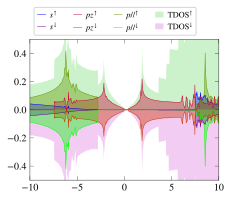

In [ ]:
ax = pp.init_figure()
pp.quick_dos_lines(files_w.value,**json.loads(v.value),color_map='brg',ax=ax)
ax.set_ylim([-0.5,0.5])
ax.set_xlim([-10,10])